In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

from tqdm.notebook import tqdm,trange

# LJ potential

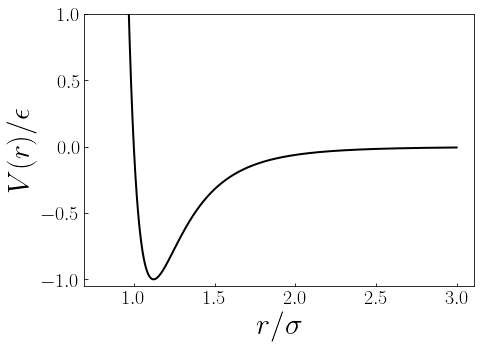

In [2]:
x = np.linspace(0.8,3,1000)
V = 4*(1/x**12 - 1/x**6)

nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax.plot(x,V,'k',lw=2)
ax.set_xlabel(r'$r/\sigma$',size=30)
ax.set_ylabel(r'$V(r)/\epsilon$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
ax.set_ylim(-1.05,1)

plt.show()
fig.savefig(r'1d-LJ-potential.pdf',bbox_inches='tight')

# Stuff

In [3]:
def get_LJ_potential(P,sig=1,eps=1):
    x = P.T[0]
    y = P.T[1]
    
    X = np.tile(x,(x.shape[0],1))
    XT = X.T

    Y = np.tile(y,(y.shape[0],1))
    YT = Y.T
    
    r = np.sqrt((X - XT)**2 + (Y - YT)**2).flatten()
    r = r[r!=0]
    
    return np.sum(4*eps*((sig/r)**12 - (sig/r)**6))/2

In [4]:
def walk(config,h=1,freeze=None):
    step = h*(2*np.random.uniform(size=config.shape)-1)
    
    if freeze is not None:
        cond = np.tile(freeze,(2,1)).T
        step *= cond
    
    return config + step

In [5]:
def minimize(config,h=1,sig=1,eps=1,rtol=1e-3,atol=1e-10,max_iter=int(1e8),freeze=None,track=False):
    configs = [config]
    U = [get_LJ_potential(config)]
    
    for i in range(max_iter):
        new_config = walk(configs[-1],h,freeze)
        new_U = get_LJ_potential(new_config,sig,eps)
        
        if new_U > U[-1]:
            continue
            
        configs.append(new_config)
        U.append(new_U)

        adiff = np.abs(new_U - U[-2])
        rdiff = np.abs(adiff/U[-2])
        if adiff < atol or rdiff < rtol:
            break
            
    if track:
        return np.array(configs),np.array(U)
    else:
        return configs[-1],U[-1]

In [6]:
def minimize1(config,h=1,sig=1,eps=1,rtol=1e-3,atol=1e-10,max_iter=int(1e8),track=False):
    configs,U = [config],[get_LJ_potential(config)]
    for i in range(N):
        freeze=np.array([j==i for j in range(N)])
        args = (h,sig,eps,rtol,atol,max_iter,freeze,True)
        configs_,U_ = minimize(configs[-1],*args)
        configs += list(configs_)
        U       += list(U_)
    
    if track:
        return np.array(configs),np.array(U)
    else:
        return configs[-1],U[-1]

track one minimization

In [11]:
h = 0.2
N = 4
L = N*2**(1/6)
P = L*np.random.uniform(size=(N,2))

results = {'method 1': {}, 'method 2': {}}
configs,U = minimize1(P,h,track=True)
results['method 1']['configs'] = configs
results['method 1']['U'] = U

configs,U = minimize(P,h,track=True)
results['method 2']['configs'] = configs
results['method 2']['U'] = U

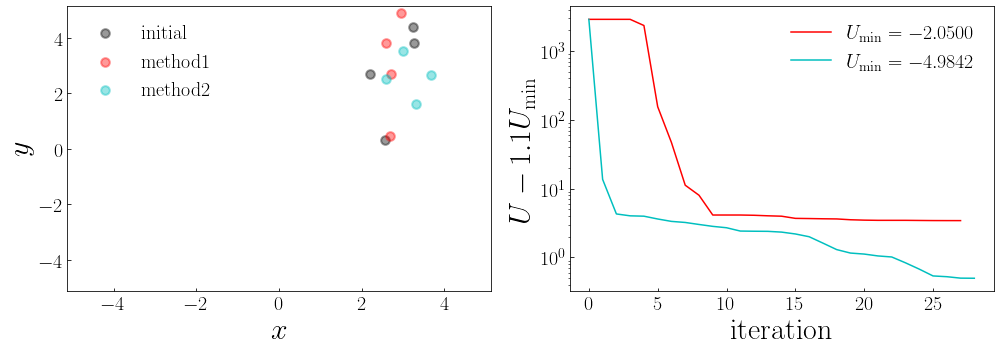

In [12]:
nrows,ncols=1,2
fig,ax=plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

x,y = configs[0].T
ax[0].scatter(x,y,marker='o',s=75,lw=2,color='k',alpha=0.4,edgecolor='k',label=r'$\rm initial$')

colors = {'method 1': 'r', 'method 2': 'c'}
Umin = min(results['method 1']['U'][-1],results['method 2']['U'][-1])
for _ in results:
    x,y = results[_]['configs'][-1].T
    ax[0].scatter(x,y,marker='o',s=75,lw=2,color=colors[_],alpha=0.4,edgecolor=colors[_],label=r'$\rm %s$'%_)
    
    U = results[_]['U']
    ax[1].plot(U-1.1*Umin,color=colors[_],label=r'$U_{\rm min} = %.4f$'%U[-1])

ax[0].legend(fontsize=20,loc='upper left',frameon=False)
ax[0].set_xlabel(r'$x$',size=30)
ax[0].set_ylabel(r'$y$',size=30)

scale = 1.05*max(np.amax(np.abs(results['method 1']['configs'])),np.amax(np.abs(results['method 2']['configs'])))
ax[0].set_xlim(-scale,scale)
ax[0].set_ylim(-scale,scale)


ax[1].set_xlabel(r'$\rm iteration$',size=30)
ax[1].set_ylabel(r'$U - 1.1 U_{\rm min}$',size=30)
ax[1].semilogy()
ax[1].legend(frameon=False,fontsize=20)
# ax[1].text(s=r'$U_{\rm min} = {%.4f}$'%Umin,size=30,x=0.95,y=0.95,ha='right',va='top',transform=ax[1].transAxes)

for i in range(2):
    ax[i].tick_params(axis='both',which='major',direction='in',labelsize=20)
ax[1].tick_params(axis='both',which='major',direction='in',labelsize=20)

plt.tight_layout()
plt.show()
fig.savefig(r'track_min%d.pdf'%N,bbox_inches='tight')

performance over batch

In [81]:
h = 0.2
N = 4
L = N*2*(1/6)

results = {'method 1': {'configs': [], 'U': []}, 'method 2': {'configs': [], 'U': []}}
for i in trange(100):
    P = L*np.random.uniform(size=(N,2))
    configs,U = minimize1(P,h,max_iter=int(1e3),track=False)
    results['method 1']['configs'].append(configs)
    results['method 1']['U'].append(U)
    
    configs,U = minimize(P,h,max_iter=int(1e6),track=False)
    results['method 2']['configs'].append(configs)
    results['method 2']['U'].append(U)
    
for _1 in results:
    for _2 in results[_1]:
        results[_1][_2] = np.array(results[_1][_2])

  0%|          | 0/100 [00:00<?, ?it/s]

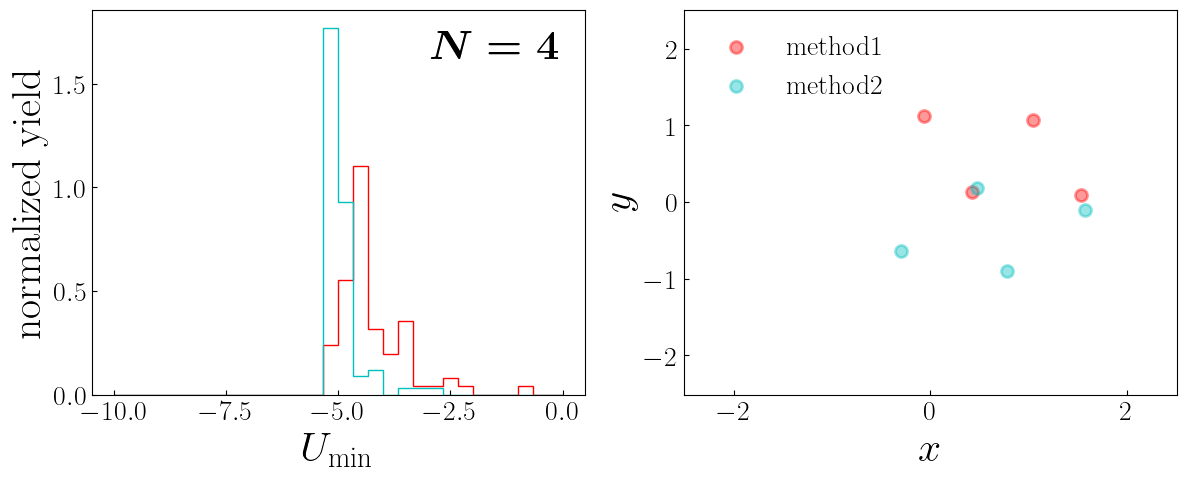

In [107]:
nrows,ncols=1,2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

colors = {'method 1': 'r', 'method 2': 'c'}
for _ in results:
    idxs = np.argsort(results[_]['U'])
    configs = results[_]['configs'][idxs]
    U = results[_]['U'][idxs]
    counts,edges = np.histogram(U,bins=30,range=(-10,0),density=True)
    ax[0].stairs(counts,edges,color=colors[_])
    
    x,y = configs[0].T
    ax[1].scatter(x,y,marker='o',s=75,lw=2,color=colors[_],alpha=0.4,edgecolor=colors[_],label=r'$\rm %s$'%_) 
    
ax[0].set_xlabel(r'$U_{\rm min}$',size=30)
ax[0].set_ylabel(r'$\rm normalized~yield$',size=30)
ax[0].text(s=r'\boldmath $N = %d$'%N,size=30,x=0.95,y=0.95,va='top',ha='right',transform=ax[0].transAxes)

ax[1].set_xlabel(r'$x$',size=30)
ax[1].set_ylabel(r'$y$',size=30)

scale = 1.05*max(np.amax(np.abs(results['method 1']['configs'])),np.amax(np.abs(results['method 2']['configs'])))
ax[1].set_xlim(-scale,scale)
ax[1].set_ylim(-scale,scale)
ax[1].legend(frameon=False,fontsize=20,loc='upper left')

for i in range(2):
    ax[i].tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()
fig.savefig(r'batch_min%d.pdf'%N,bbox_inches='tight')